# 1) Import Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

# 2) Loading in the Data

In [2]:
# Defining future parameters
IMAGE_SIZE = 100
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15
traindir = 'fruits360/fruits-360_dataset/fruits-360/Training'
testdir = 'fruits360/fruits-360_dataset/fruits-360/Test'

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
traindir, shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 67692 files belonging to 131 classes.


In [4]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
testdir, shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 22688 files belonging to 131 classes.


In [5]:
train_class_names = train_dataset.class_names
train_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [6]:
test_class_names = test_dataset.class_names
test_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [30]:
len(train_dataset)

2821

In [7]:
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 100, 100, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 23, 101,  48,  69,   3,   8, 126,  19, 128,  81, 103,  38, 100,
         3,  64,  30,   9, 105,  16, 109,  77,  60,  44,  72,  44,  21,
        16, 102,  48, 122,  17,  62])>>


# 3) Data Visualization

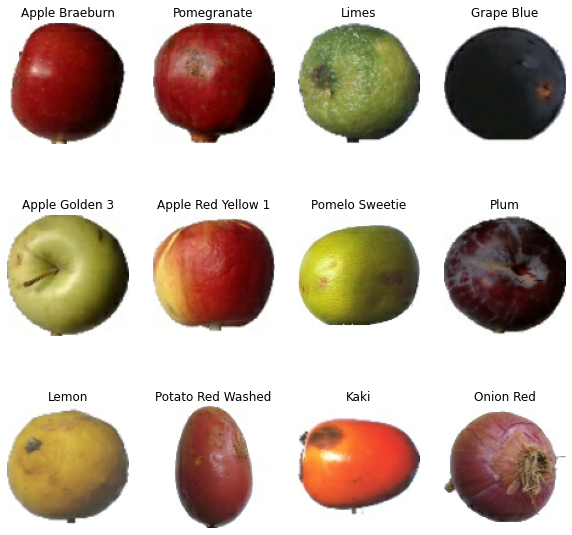

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8')) # expects a 3D array, 
        plt.title(train_class_names[label_batch[i]])
        plt.axis('off')

In [9]:
val_size = int(len(test_dataset)/2) # equal to 473
val_data = test_dataset.take(473)
test_data = test_dataset.skip(473)

In [34]:
len(test_data)

473

# 4) Data Preprocessing

In [10]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/100)
])

In [12]:
# WARNING: using RandomFlip and RandomRotation (along with 2 others) prevents the model from being saved
# in a tf.serving format and can only be saved in a h5 format
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [14]:
# Attempting to apply data augmentation to the dataset instead of the model
# WARNING: This may cause an error to occur if CPU and memory usage max out.
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                                     num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(100)
        
    # Batch all datasets    
#     ds = ds.batch(BATCH_SIZE)
    
    # Only augment the training set
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
              num_parallel_calls=AUTOTUNE)
    # Use buffered prefetching on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

train_dataset = prepare(train_dataset, shuffle=True, augment=True)
val_data = prepare(val_data)
test_data = prepare(test_data)

# 5) Model Building

In [15]:
# input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
input_shape=(IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 131
# layers.MaxPooling2D((2,2))
model = models.Sequential([
#     resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)      

In [17]:
model.compile(
optimizer='adam',
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [18]:
history = model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_data)

Epoch 1/15
2116/2116 [==============================] - 107s 43ms/step - loss: 1.4273 - accuracy: 0.5926 - val_loss: 0.7813 - val_accuracy: 0.7899
Epoch 2/15
2116/2116 [==============================] - 69s 32ms/step - loss: 0.3218 - accuracy: 0.8914 - val_loss: 0.4825 - val_accuracy: 0.8636
Epoch 3/15
2116/2116 [==============================] - 54s 25ms/step - loss: 0.1854 - accuracy: 0.9369 - val_loss: 0.4402 - val_accuracy: 0.8834
Epoch 4/15
2116/2116 [==============================] - 51s 24ms/step - loss: 0.1431 - accuracy: 0.9503 - val_loss: 0.6344 - val_accuracy: 0.8613
Epoch 5/15
2116/2116 [==============================] - 50s 23ms/step - loss: 0.1130 - accuracy: 0.9616 - val_loss: 0.5847 - val_accuracy: 0.8729
Epoch 6/15
2116/2116 [==============================] - 50s 23ms/step - loss: 0.1007 - accuracy: 0.9664 - val_loss: 0.3779 - val_accuracy: 0.9112
Epoch 7/15
2116/2116 [==============================] - 50s 23ms/step - loss: 0.0804 - accuracy: 0.9734 - val_loss: 0.3389 

In [19]:
scores = model.evaluate(test_data)

236/236 [==============================] - 9s 8ms/step - loss: 0.2988 - accuracy: 0.9502


In [20]:
history.history['accuracy']

[0.5926254391670227,
 0.891360878944397,
 0.9369053840637207,
 0.9503486156463623,
 0.9616350531578064,
 0.9664066433906555,
 0.9734089970588684,
 0.9761567115783691,
 0.9777226448059082,
 0.9787271618843079,
 0.9801306128501892,
 0.981770396232605,
 0.9808544516563416,
 0.9842374324798584,
 0.9835578799247742]

Text(0.5, 1.0, 'Training and Validation Accuracy')

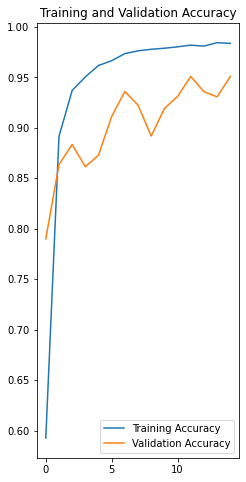

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Grape Blue
Predicted label Grape Blue


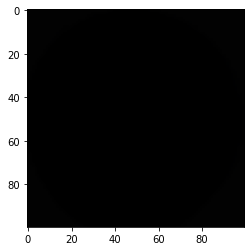

In [25]:
for images_batch, labels_batch in test_data.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label =labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', test_class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('Predicted label', test_class_names[np.argmax(batch_prediction[0])])

In [26]:
model.save('model2.h5')